In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('dataset.csv')

In [2]:
df.head()

,GridID,date,Shift,Accident,Longitude.grid,Latitude.grid
0,1,2010-10-08,Night,0,2.08,41.41
1,1,2011-02-16,Morning,0,2.08,41.41
2,1,2014-05-31,Night,0,2.08,41.41
3,1,2011-04-03,Afternoon,0,2.08,41.41
4,1,2013-02-20,Morning,0,2.08,41.41


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824587 entries, 0 to 824586
Data columns (total 6 columns):
GridID            824587 non-null int64
date              824587 non-null object
Shift             824587 non-null object
Accident          824587 non-null int64
Longitude.grid    824587 non-null float64
Latitude.grid     824587 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 37.7+ MB


In [4]:
df["Shift"].value_counts()

Afternoon    279847
Morning      277391
Night        267349
Name: Shift, dtype: int64

In [5]:
df["GridID"].value_counts()

798     747
795     737
872     737
906     721
656     715
729     697
343     690
868     686
834     686
870     683
797     682
1054    678
726     676
800     676
799     676
692     675
763     673
909     673
723     672
971     670
649     669
688     669
579     667
946     666
947     664
619     663
869     663
1019    663
580     663
502     662
       ... 
29      513
1401    512
1195    512
57      512
5       511
519     510
312     509
712     508
244     508
122     508
819     507
313     507
1379    507
194     507
678     505
48      503
353     502
84      502
23      502
1008    500
136     498
137     498
675     496
845     496
117     495
1187    493
1310    492
1274    488
68      482
891     478
Name: GridID, Length: 1445, dtype: int64

In [6]:
df["Accident"].value_counts()

0    788070
1     36517
Name: Accident, dtype: int64

In [7]:
df[""]

KeyError: ''

In [8]:
df["date"].value_counts()

2014-03-26    525
2014-05-29    519
2014-05-12    517
2014-06-24    516
2010-05-28    514
2013-04-16    508
2013-04-23    507
2012-08-12    506
2010-09-21    504
2014-11-12    503
2011-09-16    503
2012-03-30    502
2011-12-21    501
2010-11-23    501
2013-11-20    500
2014-09-12    499
2012-12-13    498
2014-10-31    497
2012-03-14    497
2010-10-25    497
2012-07-13    496
2010-08-20    495
2013-02-20    495
2014-10-28    494
2010-05-12    494
2013-05-03    494
2012-02-17    494
2014-10-08    494
2014-10-02    494
2012-07-11    493
             ... 
2014-02-24    406
2012-01-07    406
2013-05-08    404
2013-09-15    404
2010-09-29    404
2010-05-15    404
2011-07-24    403
2011-10-12    403
2012-12-17    403
2014-01-04    403
2014-06-11    403
2014-06-22    403
2013-02-05    402
2011-01-10    402
2013-11-19    402
2010-03-23    402
2012-08-07    401
2010-04-21    400
2011-02-03    400
2010-11-13    400
2011-02-15    399
2014-09-28    399
2011-05-24    398
2013-10-06    396
2013-06-30

In [9]:
df.describe()

,GridID,Accident,Longitude.grid,Latitude.grid
count,824587.000000,824587.000000,824587.000000,824587.000000
mean,725.286072,0.044285,2.157452,41.400414
std,414.478840,0.205728,0.029807,0.030844
min,1.000000,0.000000,2.080000,41.322500
25%,369.000000,0.000000,2.135000,41.382500
50%,727.000000,0.000000,2.157500,41.402500
75%,1082.000000,0.000000,2.180000,41.422500
max,1445.000000,1.000000,2.222500,41.467500


Text(0.5,0,'Años')

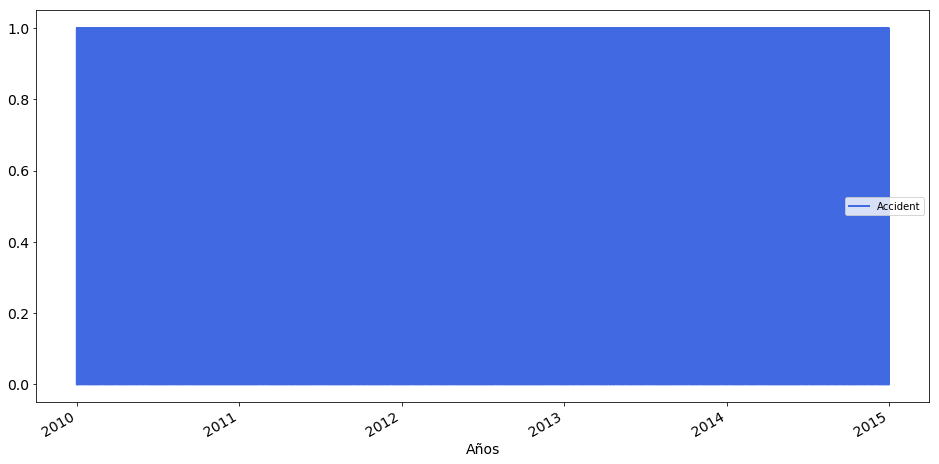

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df['date']= pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df[['Accident']].plot(figsize=(16,8), color = 'royalblue', linewidth=2,fontsize=14)
plt.xlabel('Años', fontsize=14)

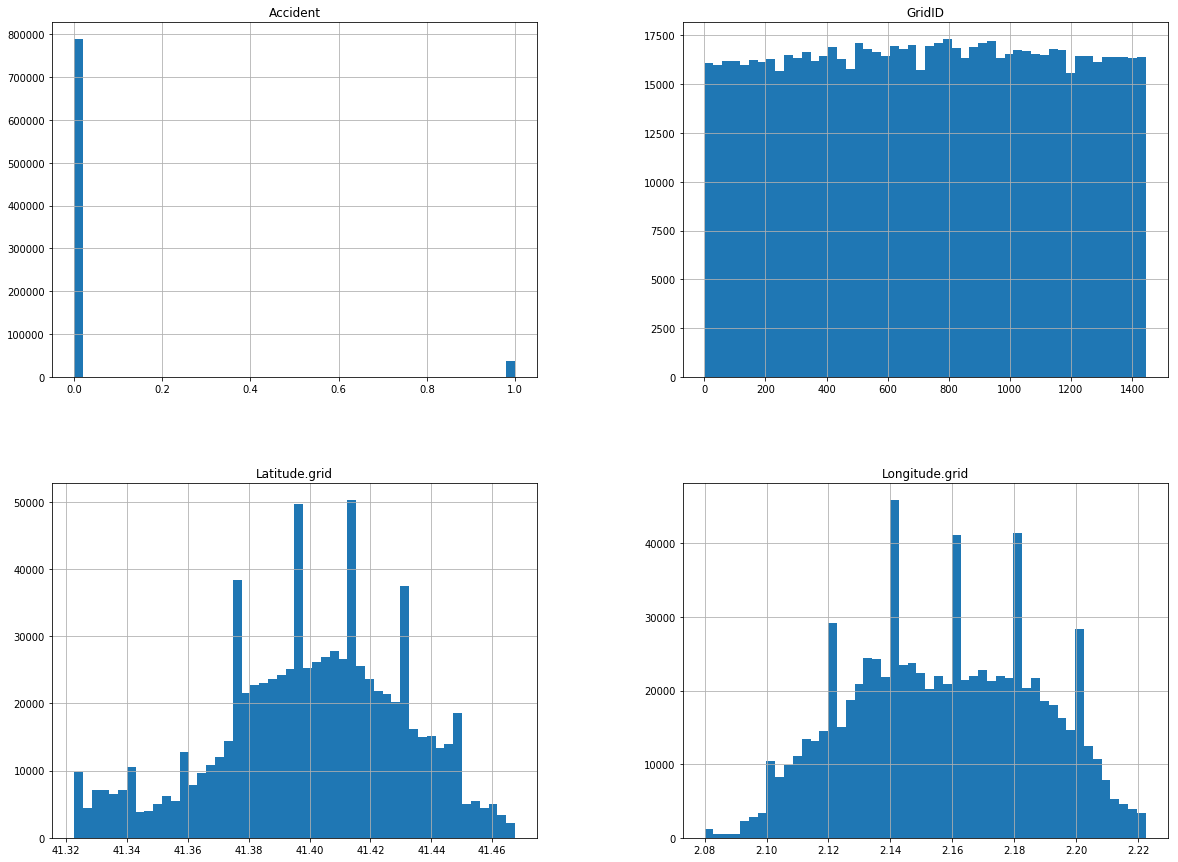

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

# Create a Test Set

In [12]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(df,0.2)
print(len(train_set), "train +", len(test_set),"test")

659670 train + 164917 test


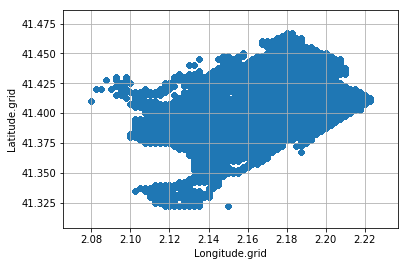

In [15]:
df.plot(kind = "Scatter", x ="Longitude.grid", y = "Latitude.grid")
plt.grid(True)

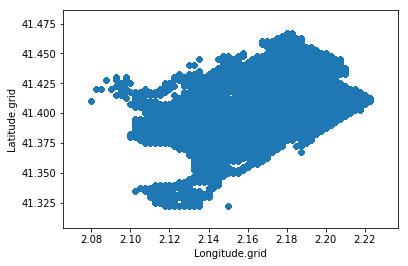

In [14]:
df.plot(kind = "Scatter", x ="Longitude.grid", y = "Latitude.grid", alpha = 0.1)